In [1]:
# Standard library imports
import os
import glob

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import librosa
import librosa.display
import moviepy.editor as mp
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D,GlobalAveragePooling3D, Input, Conv3D, MaxPooling3D, Dropout, concatenate
from keras.applications import ResNet50V2, EfficientNetB3
from sklearn import metrics
import shutil

# Import EfficientNet preprocess_input function
from keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet
# Import ResNetV2 preprocess_input function
from keras.applications.resnet_v2 import preprocess_input as preprocess_input_resnet_v2


In [2]:
# Define constants
DATASET_PATH = 'dataset'
FRAME_PATH = 'data/frames'
SPECTROGRAM_PATH = 'data/spectrograms'
MFCC_PATH = 'data/mfccs'
CLASSES = ['Quiet and Calm', 'Lively and Energetic', 'Cozy and Intimate', 'Busy and Bustling']
FRAME_INPUT_SHAPE = (10, 224, 224, 3)  # 10 frames, each frame of shape 224x224x3
SPECTROGRAM_INPUT_SHAPE = (224, 224, 3)
MFCC_INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 16
EPOCHS = 20
TEST_SIZE = 0.3

In [3]:
# Create directories if they do not exist
os.makedirs(FRAME_PATH, exist_ok=True)
os.makedirs(SPECTROGRAM_PATH, exist_ok=True)
os.makedirs(MFCC_PATH, exist_ok=True)

In [4]:
def extract_frames(video_path, frame_path):
    video = cv2.VideoCapture(video_path)
    frames = []
    last_frame = None
    fps = int(video.get(cv2.CAP_PROP_FPS))  # Get the frames per second of the video

    while video.isOpened() and len(frames) < 10:  # Only process the first 10 frames
        ret, frame = video.read()
        if not ret:
            break
        if int(video.get(cv2.CAP_PROP_POS_FRAMES)) % fps == 0:  # Only process a frame if it's a second mark
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frame = frame[:, :, :3]  # Ensure there are only 3 channels
            frame = cv2.resize(frame, (224, 224))  # Resize the frame to desired dimensions
            frames.append(frame)
            last_frame = frame

    video.release()

    # Fill up with previous frames if less than 10 frames are created
    while len(frames) < 10 and last_frame is not None:
        frames.append(last_frame)

    # Save each frame as a .png file
    for i, frame in enumerate(frames):
        image = Image.fromarray(frame)
        image.save(f"{frame_path}_{i}.png")


In [5]:
def extract_spectrogram_and_mfcc(audio_file, spectrogram_file, mfcc_file, num_mfcc=13):
    y, sr = librosa.load(audio_file)

    # Create the spectrogram
    fig, ax = plt.subplots()
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr, ax=ax)
    fig.savefig(spectrogram_file)
    plt.close(fig)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)

    # Save the MFCCs as a PNG file
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    fig.colorbar(img, ax=ax)
    fig.savefig(mfcc_file)
    plt.close(fig)

In [6]:
def extract_and_save_data():
    for ambiance in CLASSES:
        video_files = glob.glob(os.path.join(DATASET_PATH, ambiance, '*.mp4'))

        if not os.path.exists(os.path.join(FRAME_PATH, ambiance)):
                os.makedirs(os.path.join(FRAME_PATH, ambiance))

        if not os.path.exists(os.path.join(SPECTROGRAM_PATH, ambiance)):
            os.makedirs(os.path.join(SPECTROGRAM_PATH, ambiance))

        if not os.path.exists(os.path.join(MFCC_PATH, ambiance)):
            os.makedirs(os.path.join(MFCC_PATH, ambiance))

        for video_file in video_files:
            frame_path = os.path.join(FRAME_PATH, ambiance, os.path.basename(video_file).replace('.mp4', ''))
            spectrogram_path = os.path.join(SPECTROGRAM_PATH, ambiance, os.path.basename(video_file).replace('.mp4', ''))
            mfcc_path = os.path.join(MFCC_PATH, ambiance, os.path.basename(video_file).replace('.mp4', ''))

            # If frames do not exist, extract them
            if not os.path.exists(f"{frame_path}_9.png"):
                extract_frames(video_file, frame_path)

            # If spectrogram and MFCC do not exist, extract them
            if not os.path.exists(f"{spectrogram_path}.png") or not os.path.exists(f"{mfcc_path}.png"):
                audio_file = os.path.join(video_file.replace('.mp4', '.wav'))
                audio = mp.VideoFileClip(video_file).audio
                audio.write_audiofile(audio_file, verbose=False)
                extract_spectrogram_and_mfcc(audio_file, spectrogram_path, mfcc_path)
                os.remove(audio_file)

In [7]:
def load_data_into_arrays():
    X_frames, X_spectrograms, X_mfccs = [], [], []
    y = []

    label_encoder = LabelEncoder()

    for ambiance in CLASSES:
        frame_files = glob.glob(os.path.join(FRAME_PATH, ambiance, '*_0.png'))
        spectrogram_files = glob.glob(os.path.join(SPECTROGRAM_PATH, ambiance, '*.png'))
        mfcc_files = glob.glob(os.path.join(MFCC_PATH, ambiance, '*.png'))

        print(f"Found {len(frame_files)} frames, {len(spectrogram_files)} spectrograms, and {len(mfcc_files)} MFCCs for {ambiance} ambiance")

        for frame_file in frame_files:
            frames = []
            for i in range(10):
                frame_idx = min(i, len(frame_files) - 1)
                frame = Image.open(f"{frame_file.replace('_0.png', '')}_{frame_idx}.png")
                frame = frame.resize((224, 224))
                frame = np.array(frame)
                frames.append(frame)
            X_frames.append(frames)
            y.append(ambiance)

        # Load spectrograms
        for spectrogram_file in spectrogram_files:
            spectrogram = image.load_img(spectrogram_file, target_size=(224, 224))
            spectrogram = image.img_to_array(spectrogram)
            spectrogram = preprocess_input_resnet_v2(spectrogram)
            X_spectrograms.append(spectrogram)

        # Load MFCCs
        for mfcc_file in mfcc_files:
            mfcc = image.load_img(mfcc_file, target_size=(224, 224))
            mfcc = image.img_to_array(mfcc)
            mfcc = preprocess_input_efficientnet(mfcc)
            X_mfccs.append(mfcc)

    # Convert the lists to numpy arrays
    X_frames = np.array(X_frames)
    X_spectrograms = np.array(X_spectrograms)
    X_mfccs = np.array(X_mfccs)

    # Split the labels
    y = label_encoder.fit_transform(y)
    y = to_categorical(y, num_classes=len(CLASSES))

    # Split the data into training and testing sets
    X_frames_train, X_frames_test, X_spectrograms_train, X_spectrograms_test, X_mfccs_train, X_mfccs_test, y_train, y_test = train_test_split(
        X_frames, X_spectrograms, X_mfccs, y, test_size=TEST_SIZE, random_state=42
    )

    return X_frames_train, X_frames_test, X_spectrograms_train, X_spectrograms_test, X_mfccs_train, X_mfccs_test, y_train, y_test


In [ ]:
def create_image_features(input_frames):
    # Frames model
    conv1_frames = Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same')(input_frames)
    pool1_frames = MaxPooling3D(pool_size=(2, 2, 2))(conv1_frames)
    conv2_frames = Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same')(pool1_frames)
    pool2_frames = MaxPooling3D(pool_size=(2, 2, 2))(conv2_frames)
    conv3_frames = Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same')(pool2_frames)
    pool3_frames = MaxPooling3D(pool_size=(2, 2, 2))(conv3_frames)
    global_pool_frames = GlobalAveragePooling3D()(pool3_frames)

    return global_pool_frames

In [ ]:
def create_spectrogram_features(input_spectrograms):
    # Create ResNet50V2 base model for spectrograms
    base_model_spectrograms = ResNet50V2(weights='imagenet', include_top=False, input_shape=SPECTROGRAM_INPUT_SHAPE)
    base_model_spectrograms.trainable = False
    spectrogram_features = base_model_spectrograms(input_spectrograms)
    spectrogram_features = GlobalAveragePooling2D()(spectrogram_features)

    return spectrogram_features

In [ ]:
def create_mfcc_features(input_mfccs):
    # Create EfficientB3 base model for MFCCs
    base_model_mfccs = EfficientNetB3(weights='imagenet', include_top=False, input_shape=MFCC_INPUT_SHAPE)
    base_model_mfccs.trainable = False
    mfcc_features = base_model_mfccs(input_mfccs)
    mfcc_features = GlobalAveragePooling2D()(mfcc_features)

    return mfcc_features

In [8]:
def create_model():
    FRAME_INPUT_SHAPE = (10, 224, 224, 3)
    SPECTROGRAM_INPUT_SHAPE = (224, 224, 3)
    MFCC_INPUT_SHAPE = (224, 224, 3)
    
    # Define input layers for frames, spectrograms, and MFCCs
    input_frames = Input(shape=FRAME_INPUT_SHAPE)
    input_spectrograms = Input(shape=SPECTROGRAM_INPUT_SHAPE)
    input_mfccs = Input(shape=MFCC_INPUT_SHAPE)

    image_features = create_image_features(input_frames)
    spectrogram_features = create_spectrogram_features(input_spectrograms)
    mfcc_features = create_mfcc_features(input_mfccs)

    # Concatenate features from all inputs
    concatenated_features = concatenate([image_features, spectrogram_features, mfcc_features])

    # Add dense layers for classification
    dense_layer = Dense(256, activation='relu')(concatenated_features)
    dropout_layer = Dropout(0.5)(dense_layer)
    output_layer = Dense(len(CLASSES), activation='softmax')(dropout_layer)

    # Create the model
    model = Model(inputs=[input_frames, input_spectrograms, input_mfccs], outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
def train_model(model, X_frames_train, X_frames_test, X_spectrograms_train, X_spectrograms_test, X_mfccs_train, X_mfccs_test, y_train, y_test):

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        [X_frames_train, X_spectrograms_train, X_mfccs_train], y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=([X_frames_test, X_spectrograms_test, X_mfccs_test], y_test),
        callbacks=[early_stopping])

    model.save('fusion_model.keras')
    return history

In [10]:
# Preprocess data
extract_and_save_data()

In [11]:
X_frames_train, X_frames_test, X_spectrograms_train, X_spectrograms_test, X_mfccs_train, X_mfccs_test, y_train, y_test = load_data_into_arrays()

Found 829 frames, 829 spectrograms, and 829 MFCCs for Quiet and Calm ambiance
Found 931 frames, 931 spectrograms, and 931 MFCCs for Lively and Energetic ambiance
Found 1018 frames, 1018 spectrograms, and 1018 MFCCs for Cozy and Intimate ambiance
Found 708 frames, 708 spectrograms, and 708 MFCCs for Busy and Bustling ambiance


In [12]:
print(f"Training with {len(X_frames_train)} frames, {len(X_spectrograms_train)} spectrograms, and {len(X_mfccs_train)} MFCCs")
print(f"Testing with {len(X_frames_test)} frames, {len(X_spectrograms_test)} spectrograms, and {len(X_mfccs_test)} MFCCs")
model = create_model()

Training with 2440 frames, 2440 spectrograms, and 2440 MFCCs
Testing with 1046 frames, 1046 spectrograms, and 1046 MFCCs


In [13]:
history = train_model(model, X_frames_train, X_frames_test, X_spectrograms_train, X_spectrograms_test, X_mfccs_train, X_mfccs_test, y_train, y_test)

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 596s 4s/step - accuracy: 0.4664 - loss: 2.5864 - val_accuracy: 0.7409 - val_loss: 0.6773
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.7064 - loss: 0.7398 - val_accuracy: 0.7849 - val_loss: 0.5528
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 565s 4s/step - accuracy: 0.7903 - loss: 0.5440 - val_accuracy: 0.8098 - val_loss: 0.4335
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.8238 - loss: 0.4499 - val_accuracy: 0.8480 - val_loss: 0.3748
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.8263 - loss: 0.4114 - val_accuracy: 0.8690 - val_loss: 0.3195
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.8583 - loss: 0.3680 - val_accuracy: 0.8633 - val_loss: 0.3379
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.8804 - loss: 0.3079 - val_accuracy: 0.9054 - val_loss: 0.2631
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.9079 - loss: 0.2514 - val_accu

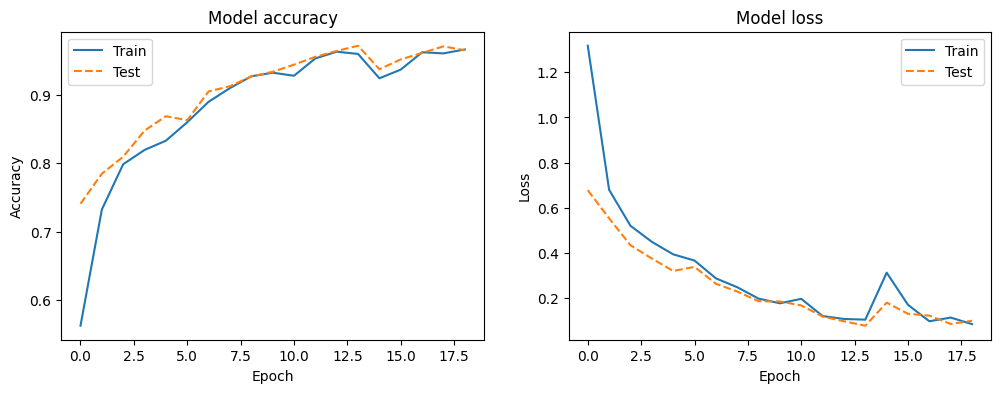

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], '--', label='Test')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], '--', label='Test')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step
y_test shape: (1046, 4)
y_pred_classes shape: (1046,)
y_test data type: float64
y_pred_classes data type: int64


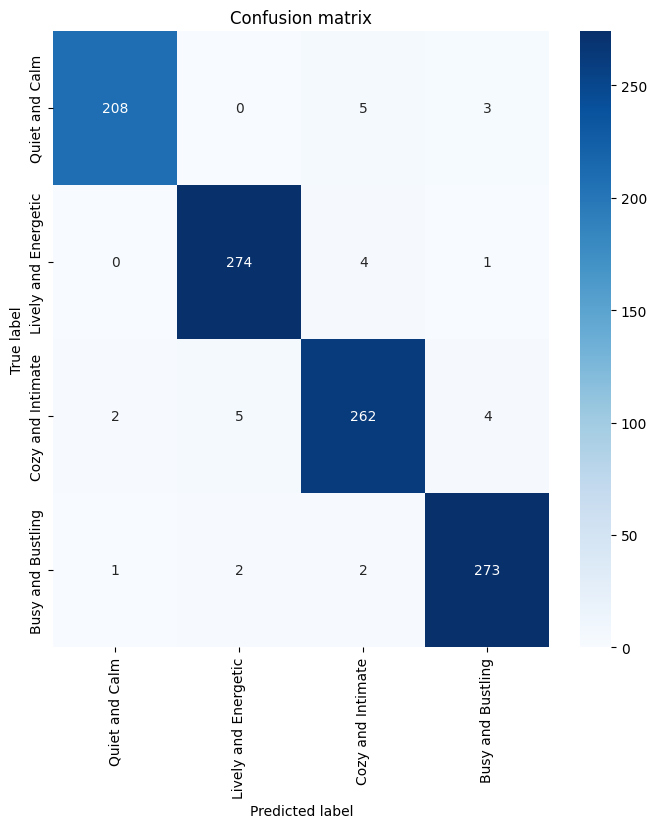

In [15]:
# Get the model's predictions on the test data
y_pred = model.predict([X_frames_test, X_spectrograms_test, X_mfccs_test])
y_pred_classes = np.argmax(y_pred, axis=1)

print("y_test shape:", y_test.shape)
print("y_pred_classes shape:", y_pred_classes.shape)
print("y_test data type:", y_test.dtype)
print("y_pred_classes data type:", y_pred_classes.dtype)

# Reshape y_test
y_test_labels = np.argmax(y_test, axis=1)

# Convert data type to integer
y_test_labels = y_test_labels.astype(np.int64)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
def evaluate(true_labels, predicted_labels):
    accuracy = metrics.accuracy_score(true_labels, predicted_labels)
    f1_score = metrics.f1_score(true_labels, predicted_labels, average='weighted')
    recall = metrics.recall_score(true_labels, predicted_labels, average='weighted')
    precision = metrics.precision_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1_score}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')

In [17]:
# Convert the true labels to a 1D array of class labels
y_test_labels = np.argmax(y_test, axis=1)

# Convert the predicted labels to a 1D array
y_pred_labels = y_pred_classes

# Call the evaluate function with the modified arrays
evaluate(y_test_labels, y_pred_labels)

Accuracy: 0.9722753346080306
F1 Score: 0.9722675998872412
Recall: 0.9722753346080306
Precision: 0.9723366551332051


In [18]:
def preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path):
    # Remove previous directories if they exist
    for path in [frame_path, spectrogram_path, mfcc_path]:
        if os.path.exists(path):
            shutil.rmtree(path)
            
    # Ensure directories for saving extracted data exist
    os.makedirs(frame_path, exist_ok=True)
    os.makedirs(spectrogram_path, exist_ok=True)
    os.makedirs(mfcc_path, exist_ok=True)

    frame_loc = os.path.join(frame_path, os.path.basename(video_path).replace('.mp4', ''))
    spectrogram_loc = os.path.join(spectrogram_path, os.path.basename(video_path).replace('.mp4', ''))
    mfcc_loc = os.path.join(mfcc_path, os.path.basename(video_path).replace('.mp4', ''))

    extract_frames(video_path, frame_loc)
    extract_spectrogram_and_mfcc(video_path, spectrogram_loc, mfcc_loc)

    # Load preprocessed data
    X_frames, X_spectrograms, X_mfccs = load_preprocessed_data(frame_path, spectrogram_path, mfcc_path)

    return X_frames, X_spectrograms, X_mfccs

def load_preprocessed_data(frame_path, spectrogram_path, mfcc_path):
    X_frames, X_spectrograms, X_mfccs = [], [], []
    # Load frames
    frame_files = glob.glob(os.path.join(frame_path, '*.png'))
    frames = []
    for frame_file in frame_files:        
        frame_path = os.path.join(frame_file)  # Construct full frame file path
        frame = Image.open(frame_path)  # Open the frame image
        frame = frame.resize((224, 224))
        frame = np.array(frame)
        frames.append(frame)
    # Convert frames list to a numpy array and append it to X_frames
    X_frames.append(np.array(frames))
    # Convert X_frames to a numpy array
    X_frames = np.array(X_frames)

    # Load spectrograms
    spectrogram_files = glob.glob(os.path.join(spectrogram_path, '*.png'))
    X_spectrograms = []
    for spectrogram_file in spectrogram_files:
        spectrogram = image.load_img(spectrogram_file, target_size=(224, 224))
        spectrogram = image.img_to_array(spectrogram)
        spectrogram = preprocess_input_resnet_v2(spectrogram)
        X_spectrograms.append(spectrogram)
    X_spectrograms = np.array(X_spectrograms)

    # Load MFCCs
    mfcc_files = glob.glob(os.path.join(mfcc_path, '*.png'))
    X_mfccs = []
    for mfcc_file in mfcc_files:
        mfcc = image.load_img(mfcc_file, target_size=(224, 224))
        mfcc = image.img_to_array(mfcc)
        mfcc = preprocess_input_efficientnet(mfcc)
        X_mfccs.append(mfcc)
    X_mfccs = np.array(X_mfccs)

    return X_frames, X_spectrograms, X_mfccs

def predict_ambiance(model, X_frames, X_spectrograms, X_mfccs):
    # Make predictions using the model
    predictions = model.predict([X_frames, X_spectrograms, X_mfccs])
    return predictions


In [19]:
# Define your model
test_model = keras.saving.load_model("fusion_model.keras")

# Set paths for saving preprocessed data
frame_path = 'output/frames'
spectrogram_path = 'output/spectrograms'
mfcc_path = 'output/mfccs'

In [20]:
# Path to your video file
video_path = 'samples/busy_sample.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Probability of Quiet and Calm: 3.011632609961623e-10
Probability of Lively and Energetic: 1.765553747645754e-07
Probability of Cozy and Intimate: 7.922142231109319e-08
Probability of Busy and Bustling: 0.9999997615814209
Predicted ambiance: Busy and Bustling


In [26]:
# Path to your video file
video_path = 'samples/busy_sample2.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Probability of Quiet and Calm: 1.9511071869260377e-08
Probability of Lively and Energetic: 3.5432867662166245e-06
Probability of Cozy and Intimate: 4.757734586746665e-06
Probability of Busy and Bustling: 0.9999916553497314
Predicted ambiance: Busy and Bustling


In [21]:
# Path to your video file
video_path = 'samples/lively_sample.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Probability of Quiet and Calm: 1.790672373835206e-13
Probability of Lively and Energetic: 1.0
Probability of Cozy and Intimate: 4.828713809637092e-17
Probability of Busy and Bustling: 1.6381515555944498e-15
Predicted ambiance: Lively and Energetic


In [27]:
# Path to your video file
video_path = 'samples/lively_sample2.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Probability of Quiet and Calm: 8.96342624689267e-13
Probability of Lively and Energetic: 1.0
Probability of Cozy and Intimate: 1.0956040491071767e-13
Probability of Busy and Bustling: 2.038661123596186e-12
Predicted ambiance: Lively and Energetic


In [22]:
# Path to your video file
video_path = 'samples/cozy_sample.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Probability of Quiet and Calm: 5.775418117082154e-07
Probability of Lively and Energetic: 1.6405708791467077e-08
Probability of Cozy and Intimate: 0.9999959468841553
Probability of Busy and Bustling: 3.4640215744730085e-06
Predicted ambiance: Cozy and Intimate


In [25]:
# Path to your video file
video_path = 'samples/cozy_sample2.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Probability of Quiet and Calm: 0.004586691968142986
Probability of Lively and Energetic: 0.02703220024704933
Probability of Cozy and Intimate: 0.9556114673614502
Probability of Busy and Bustling: 0.012769603170454502
Predicted ambiance: Cozy and Intimate


In [23]:
# Path to your video file
video_path = 'samples/quiet_sample.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Probability of Quiet and Calm: 0.9993484616279602
Probability of Lively and Energetic: 1.4117503610577842e-07
Probability of Cozy and Intimate: 0.0006512542022392154
Probability of Busy and Bustling: 1.5108651041373378e-07
Predicted ambiance: Quiet and Calm


In [24]:
# Path to your video file
video_path = 'samples/quiet_sample2.mp4'

# Preprocess the video for prediction
X_frames, X_spectrograms, X_mfccs = preprocess_video_for_prediction(video_path, frame_path, spectrogram_path, mfcc_path)

# Predict ambiance
predictions = predict_ambiance(test_model, X_frames, X_spectrograms, X_mfccs)

# Display the predicted probabilities for each class
for i, probability in enumerate(predictions[0]):
    ambiance = CLASSES[i]
    print(f"Probability of {ambiance}: {probability}")

# Get the index with the highest probability
predicted_index = np.argmax(predictions)
# Get the predicted ambiance label
predicted_ambiance = CLASSES[predicted_index]
# Print the predicted ambiance label
print("Predicted ambiance:", predicted_ambiance)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Probability of Quiet and Calm: 0.9999220371246338
Probability of Lively and Energetic: 7.149016596486035e-07
Probability of Cozy and Intimate: 7.617379014845937e-05
Probability of Busy and Bustling: 1.0336195828131167e-06
Predicted ambiance: Quiet and Calm
